![logo](https://www.gromacs.org/_static/gmx_logo_blue.png)


## 💻 Instalação
📖 [Documentação](https://manual.gromacs.org)

**1. Baixar o source code da versão do GROMACS desejada.**
- Levar em consideração o poder de computação da sua GPU [CUDA GPU Compute Capability](https://developer.nvidia.com/cuda-gpus)
- Verificar a versão do CUDA instalada pelo comando **nvdia-smi** no terminal Linux
- Se a GPU estiver atualizada e com um poder de computação equivalente a versão do GROMACS, pode prosseguir.
- Para utilizar o modo GPU, é necessário instalar o [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit) (Não precisa subscrever o Driver)
- Após a instalação, realizar o chmod -x para tornar o arquivo executável e assim configurar o CUDA Toolkit

**2. Criar um novo diretório "softwares" no /**
- Alternativa para organizar melhor os programas
- Caso já tenha, desconsiderar esse passo

**3. Descompactar o arquivo de source code tar.gz**
- WSL -> Colocar o arquivo(gromacs-2024.2.tar.gz) no diretório softwares
- tar -xvzf gromacs-2024.2.tar.gz -> Extrair o arquivo no diretório atual
- copiar o diretório gromacs-2024.2 para criar o diretório que será utilizado para DOUBLE precision
- agora teremos dois diretórios (gromacs-2024.2) e (gromacs-2024.2-double)

**4. Criar novo diretório "build" na pasta do gromacs-2024.2**
- cd gromacs-2024.2 ou gromacs-2024.2-double -> Fazer um por vez
- mkdir build
- cd build

**5. Utilizar o compilador C++ (cmake) para fazer a compilação dos arquivos**
- sudo apt install cmake
- cmake .. -DGMX_BUILD_OWN_FFTW=ON -DREGRESSIONTEST_DOWNLOAD=ON -> Adicionar os parâmetros
- cmake .. -DGMX_BUILD_OWN_FFTW=ON -DREGRESSIONTEST_DOWNLOAD=ON -DGMX_GPU=CUDA -DCMAKE_BUILD_TYPE=Debug -> **GPU**
- cmake .. -DGMX_BUILD_OWN_FFTW=ON -DREGRESSIONTEST_DOWNLOAD=ON -DGMX_DOUBLE=on -DCMAKE_BUILD_TYPE=Debug -> **DOUBLE PRECISION**

**6. Realizar a Compilação**
- make
- make check
- sudo make install
- source /usr/local/gromacs/bin/GMXRC (Adicionar esse path nas variáveis de ambiente /home/user/.bashrc)

**7. Instalação do VMD**
- tar -xvzf vmd.tar.gz -> Descompactar o arquivo
- cd vmd-1.9.3 -> Entrar na pasta
- ./configure -> Entrar nas configurações
- cd src -> Entrar na pasta do make
- sudo make install -> Instalar e compilar o VMD
- vmd -> Acessar o VMD

**8. Possíveis Erros**
- Erro de Compilação por versão do CUDA e de drivers
- Solução: Forçar o cmake a ir no diretório da versão do CUDA desejada
- CUDACXX=/usr/local/cuda-12.5/bin/nvcc cmake .. -DGMX_GPU=CUDA -DREGRESSIONTEST_DOWNLOAD=ON -DGMX_BUILD_OWN_FFTW=ON -DCMAKE_BUILD_TYPE=Debug


## 📘 Protocolo - Primeira Etapa
📌 [Tutorial](http://www.mdtutorials.com/gmx/index.html)

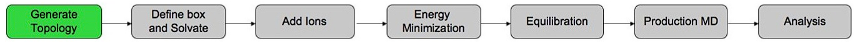

**1. Preparação do arquivo .pdb**
- Baixar o arquivo pdb da proteína ou utilizar o modelo criado .pdb
- Remover todos os cristais de água -> grep -v HOH código.pdb > código_clean.pdb
- Vamos utilizar o módulo pdb2gmx para gerar o arquivo de topologia
- gmx pdb2gmx -f código_clean.pdb -o código_processed.gro -water spce

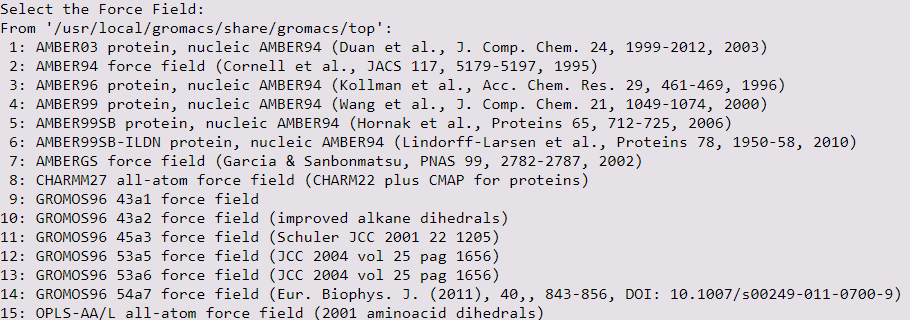

**2. Definir o campo de força**
- Irá aparecer um prompt para escolher o campo de força que será utilizado
- No tutorial é utilizado o campo de força número **15**
- Parâmetros que podem ser utilizados:
- -ignh (Ignora os hidrogênios), 
- -ter (Declara os estados de carga do N e C terminal), 
- -inter (Declara os estados de carga de Glu, Asp, Lys, Arg e His)
- Agora vamos ter três novos arquivos -> código_processed.gro, topol.top e posre.itp
- código_processed.gro -> Arquivo de estrutura formatado em GROMACS que contém todos os átomos definidos no campo de força
- topol.top -> Arquivo que contém a topologia
- posre.itp -> O arquivo que contém informações usadas para restringir as posições de átomos pesados

**3. Análise e tratamento do arquivo de topologia**
- Inspecionar o output do arquivo de topologia (topol.top) -> #include "oplsaa.ff/forcefield.itp"

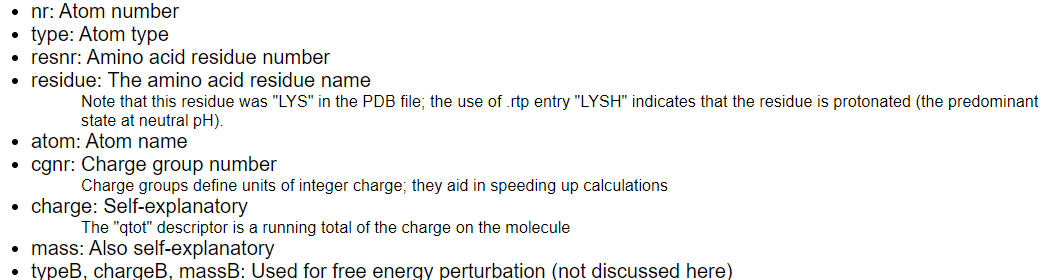


## 📕 Protocolo - Segunda Etapa

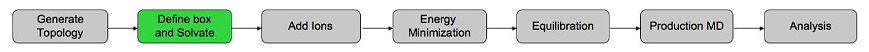

**1. Definir a caixa de solvatação**
- Módulo editconf
- Caixas de diferentes tamanhos e formatos (cubic, rhombic dodecahedron...)
- gmx editconf -f código_processed.gro -o código_newbox.gro -c -d 1.0 -bt cubic

**2. Preencher a caixa com o solvente**
- Módulo solvate
- Podem ser utilizados diferentes tipos de solventes e diferentes [tipos de água](https://water.lsbu.ac.uk/water/water_models.html).
- gmx solvate -cp código_newbox.gro -cs spc216.gro -o código_solv.gro -p topol.top
- Output -> código_solv.gro

## 📗 Protocolo - Terceira Etapa

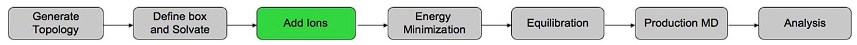

**1. Adição de íons para equilibrar o sistema**
- Para equilibrar a carga, devemos adicionar íons ao nosso sistema.
- Módulo genion -> Faz a troca de algumas moléculas de água por íons
- Módulo grompp -> Processa o arquivo de coordenadas e a topologia para gerar uma entrada de nível atômico (.tpr)
- Arquivo .tpr -> Contém todos os parâmetros para todos os átomos do sistema.
- Para produzir um arquivo .tpr com grompp, precisaremos de um arquivo de entrada adicional, com extensão .mdp (arquivo de parâmetros de dinâmica molecular)
- Um arquivo .mdp normalmente é usado para executar a minimização de energia ou uma simulação MD, mas neste caso é usado simplesmente para gerar uma descrição atômica do sistema.
- gmx grompp -f ions.mdp -c código_solv.gro -p topol.top -o ions.tpr
- Agora temos uma descrição em nível atômico do nosso sistema no arquivo binário ions.tpr. Passaremos esse arquivo para o genion:
- gmx genion -s ions.tpr -o código_solv_ions.gro -p topol.top -pname NA -nname CL -neutral
- Quando solicitado, escolha o grupo **13 "SOL"** para incorporar íons.
- Não use nomes de átomos ou resíduos no comando genion, ou você encontrará erros nas etapas subsequentes.





## 📙 Protocolo - Quarta Etapa

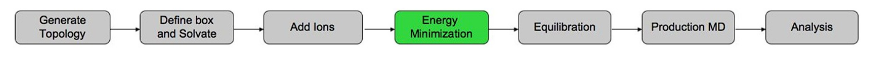

**1. Minimização de Energia**
- Antes de realizar a simulação, devemos garantir que o sistema não tenha conflitos estéricos ou geometria inadequada.
- A estrutura é relaxada através de um processo chamado minimização de energia (EM)
- Mais uma vez usaremos o grompp para montar a estrutura, topologia e parâmetros de simulação em um arquivo de entrada binário (.tpr)
- Mas desta vez, em vez de passar o .tpr para o genion, executaremos a minimização de energia através do mecanismo GROMACS MD, mdrun.
- gmx grompp -f minim.mdp -c código_solv_ions.gro -p topol.top -o em.tpr
- gmx mdrun -v -deffnm em -> Realiza a minimização de energia

**2. Arquivos gerados pela EM**
- em.log: ASCII-text log file of the EM process
- em.edr: Binary energy file
- em.trr: Binary full-precision trajectory
- em.gro: Energy-minimized structure

**3. Análise da EM**
- O valor de epot (printado no fim do processo) deve ser negativo
- Epot + Fmax > emtol -> Seu sistema pode não ser estável o suficiente para simulação.
- O arquivo em.edr contém todos os termos de energia que o GROMACS coleta durante o EM
- gmx energy -f em.edr -o potential.xvg
- No prompt, digite “10 0” para selecionar Potencial (10); zero (0) encerra a entrada.
- Será mostrada a média do Epot e um arquivo chamado "potential.xvg" será produzido
- Para plotar esses dados, você precisará da ferramenta de plotagem Xmgrace
- xmgrace potential.xvg

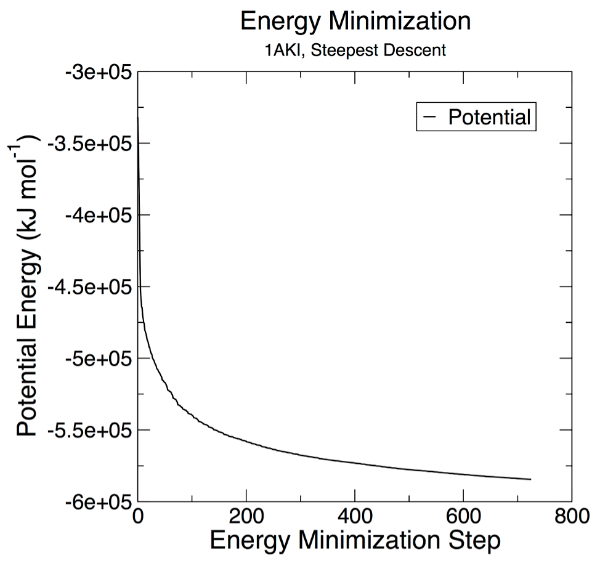

## 📓 Protocolo - Quinta Etapa

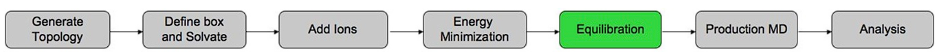

**1. Equilibração do Sistema**
- Para iniciar a dinâmica real, devemos equilibrar o solvente e os íons ao redor da proteína.
- Ajuste de temperatura e de pressão do sistema com solvente e soluto (proteína)
- Vamos utilizar o arquivo posre.itp gerado pelo módulo pdb2gmx e um arquivo .mdp (parâmetros)
- Para estabilizar a temperatura iremos utilizar:
- gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr
- gmx mdrun -deffnm nvt

**2. Análise da Progressão de Temperatura**
- Vamos utilizar o módulo energy
- gmx energy -f nvt.edr -o temperature.xvg
- Digite “16 0” no prompt para selecionar a temperatura do sistema e sair.
- xmgrace temperature.xvg
- O plot deve parecer com esse:

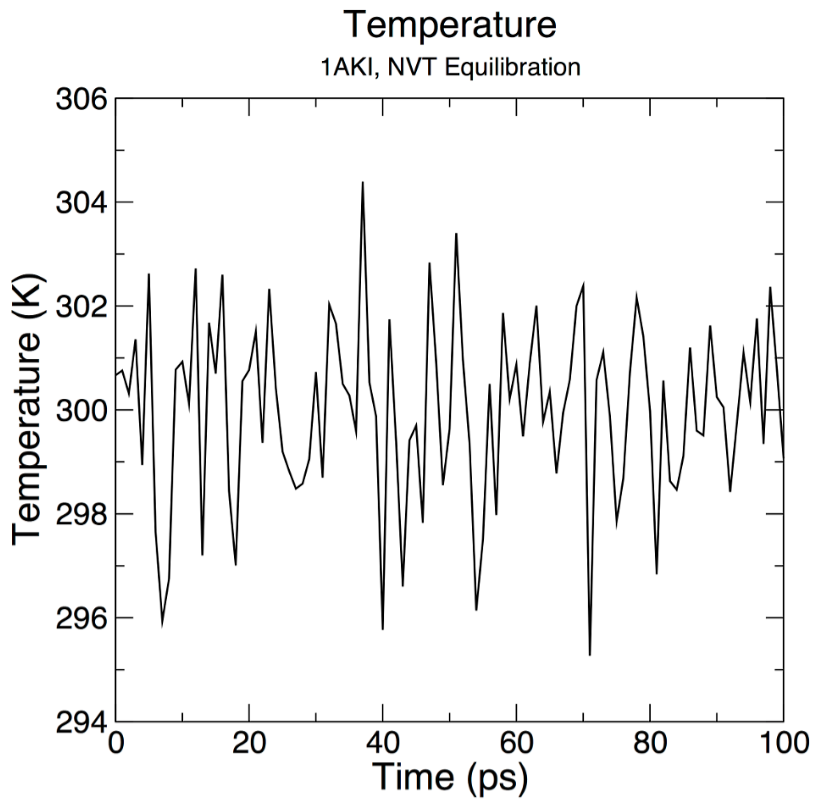

**3. Estabilização da Pressão**
- Também é necessário um arquivo de parâmetros (.mdp)
- Vamos utilizar o grompp e o mdrun
- gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr
- gmx mdrun -deffnm npt
- Para analisar a progressão da pressão:
- gmx energy -f npt.edr -o pressure.xvg
- Digite “18 0” no prompt para selecionar a pressão do sistema e sair.
- xmgrace pressure.xvg

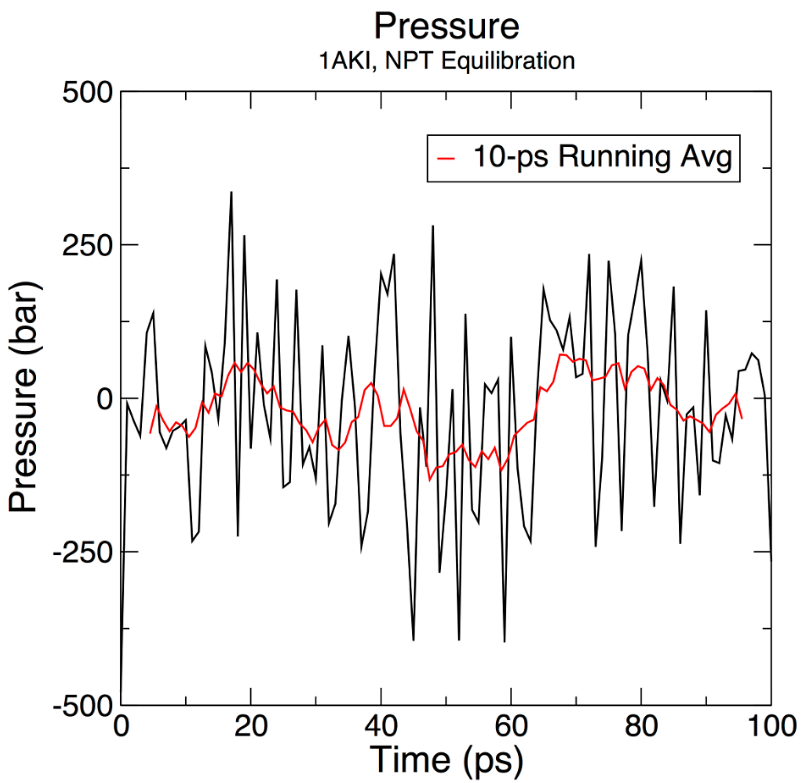

**4. Análise da Densidade**
- gmx energy -f npt.edr -o density.xvg
- Digite “24 0” no prompt para selecionar a densidade do sistema e sair.
- xmgrace density.xvg

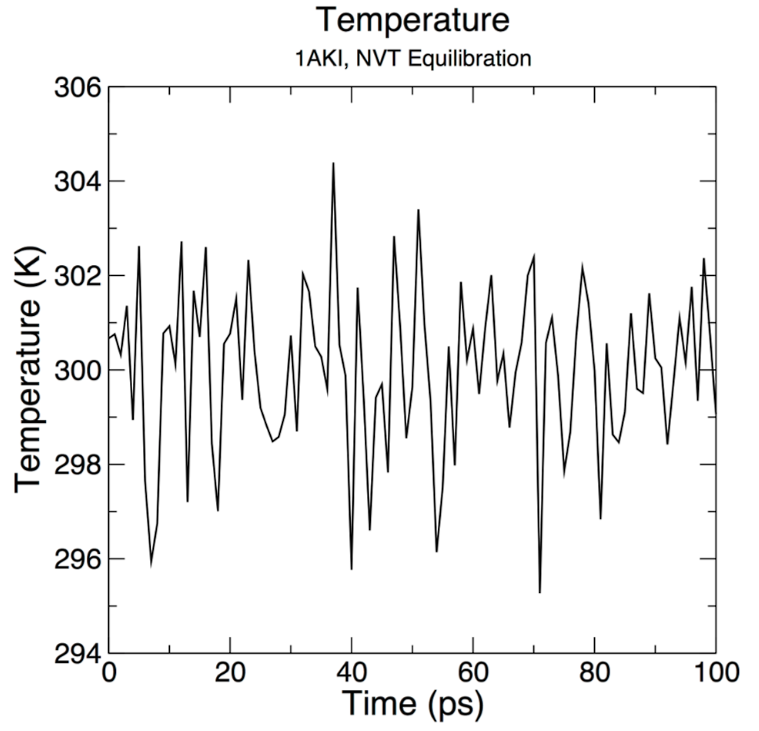



## 📒 Protocolo - Sexta Etapa

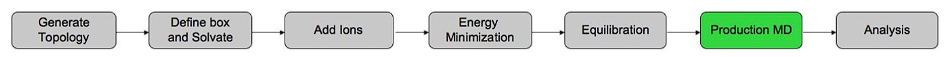

**1. Simulação de Dinâmica Molecular**
- Após a equilibração é realizada a simulação de dinâmica molecular
- É necessário baixar o script de simulação (1-ns)
- gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md_0_1.tpr
- grompp irá imprimir na tela uma estimativa da carga computacional relativa necessária (PME e PP)
- Estimate for the relative computational load of the PME mesh part: 0.22
- Para uma caixa cúbica, a configuração ideal terá uma carga de PME de 0,25 (3:1 PP:PME)
- Para uma caixa dodecaédrica, a carga PME ideal é 0,33 (2:1 PP:PME)
- Agora execute o mdrun:
- gmx mdrun -deffnm md_0_1 (CPU)
- gmx mdrun -deffnm md_0_1 -nb gpu (GPU)


## 📊 Protocolo - Análise

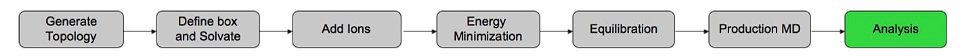

**1. Correção de trajetória**
- Centralizar a proteína na solução para corrigir a trajetória 
- Módulo trjconv
- gmx trjconv -s md_0_1.tpr -f md_0_1.xtc -o md_0_1_noPBC.xtc -pbc mol -center
- No prompt selecione 1 ("Proteína") como o grupo a ser centralizado e 0 ("Sistema") para saída

**2. Cálculo do RMSD**
- Agora vamos fazer as análises nesse arquivo com a trajetória corrigida
- Módulo rms (RMSD)
- gmx rms -s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsd.xvg -tu ns
- Escolha 4 ("Backbone") tanto para o ajuste de mínimos quadrados quanto para o grupo para cálculo RMSD.
- Para calcular o RMSD relativo a estrutura cristalizada:
- gmx rms -s em.tpr -f md_0_1_noPBC.xtc -o rmsd_xtal.xvg -tu ns
- Usar o xmgrace para plotar os dois resultados: xmgrace rmsd.xvg rmsd_xtal.xvg

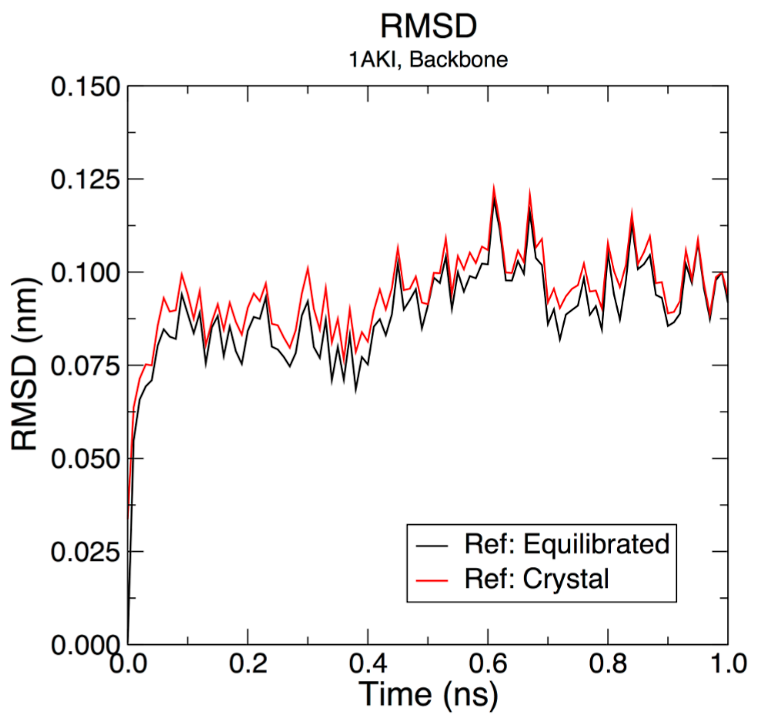

**3. Raio de Giro**
- O raio de giração de uma proteína é uma medida de sua compactação.
- Ele analisa a estabilidade da proteína para se manter compacta
- Módulo gyrate
- gmx gyrate -s md_0_1.tpr -f md_0_1_noPBC.xtc -o gyrate.xvg
- No prompt, escolha 1 (Proteína) para a análise
- Para plotar o gráfico: xmgrace gyrate.xvg

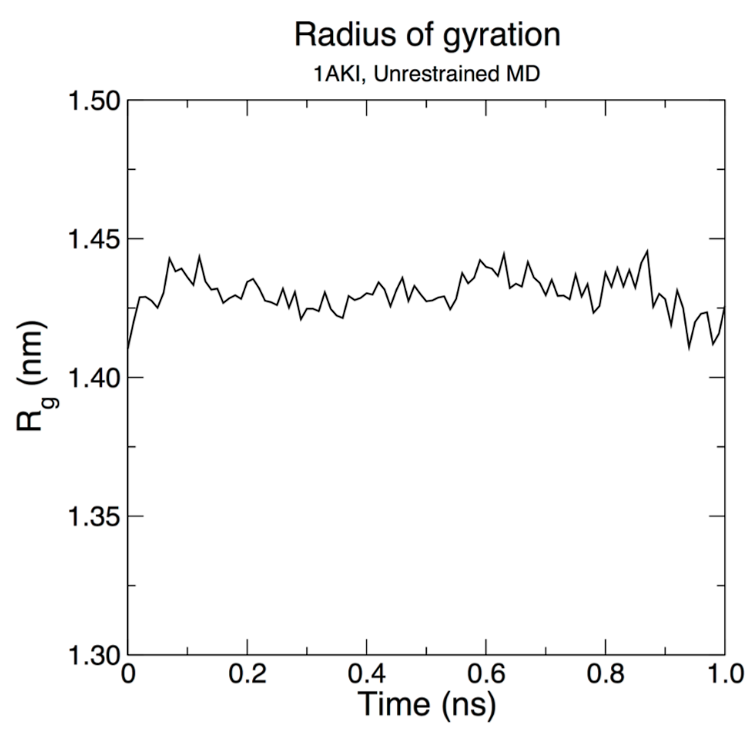

**4. Estrutura Secundária**
- Detecção de padrões específicos de ligações de hidrogênio entre resíduos de aminoácidos
- Módulo dssp
- gmx dssp -s step5_1.tpr -f step5_full_fit.xtc -o dssp.dat -num num.xvg -tu ns
- No prompt, escolha 1 (Proteína) para a análise
- Para plotar: xmgrace num.nvg

**5. Cálculo de RMSF**
- Calcula a raiz quadrada média da flutuação (RMSF)
- Módulo rmsf
- gmx rmsf -s step5_1.tpr -f step5_full_fit.xtc -o RMSF.xvg -res -oq bfac.pdb -ox xaver.pdb
- Plot: xmgrace RMSF.xvg
- Visualizar o bfac.pdb no PyMol

**6. Superfícies Acessíveis**
- Calcula áreas de superfície acessíveis ao solvente.
- Módulo sasa
- gmx sasa -s step5_1.tpr -f step5_full_fit.xtc -o area-total.xvg -or resarea-toral.xvg -tu ns
- Dá para plotar tanto em área total como por resíduo